## Validate dark cal coordinates and compare to dynamic dark map

Use dynamic dark current sampling (on-the-fly warm pixels) in order to explicitly compare known pixel coordinate values to those in a dark cal map which is read by `aca_dark` routines.  This validates that the row/col coordinates in a dark map, accessed using the new standard `dark_map.aca[row, col]` idiom, is correct.

Side goals:
- Demonstrate a real-world use of the `ACAImage` class from `chandra_aca.aca_image`
- Investigate for one case the variability of warm/hot pixels

In [1]:
import numpy as np

from Chandra.Time import DateTime
from kadi import events
from mica.archive import aca_l0, aca_dark
from chandra_aca.aca_image import ACAImage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
obsid = 50804  # Our favorite obsid with a faint star in slot 7
slot = 7
dwells = events.dwells.filter(obsid=obsid)
tstart = dwells[0].tstart
dur = 1000

# Get 1000 seconds of images
imgs = aca_l0.get_l0_images(tstart, tstart + dur, slot=7)

In [3]:
# Make a stack of 100 images (30x30) to hold dynamic dark current samples.
# This is an alternate implementation from the keyed deque version.
max_n_samples = 100
sz = 32  # +/- 16 pixels is plenty big
row0 = imgs[0].row0 - sz/2
col0 = imgs[0].col0 - sz/2

# Stack (list) of pixel samples (ACAImage objects)
samples = [ACAImage(shape=(sz, sz), row0=row0, col0=col0) for i in range(max_n_samples)]

# Keep track of how many samples for each pixel
n_samples = ACAImage(shape=(sz, sz), row0=row0, col0=col0, dtype=int)

In [4]:
# Trick to get a list of (r, c) tuples corresponding to the edge of 8x8 image
x = np.ones((8, 8))
x[1:7, 1:7] = 0
rcs = zip(*np.where(x == 1))

# Do the actual work of collecting samples.  If there are more than
# max_n_samples then roll over.
for img in imgs:
    for r, c in rcs:
        row, col = r + img.row0, c + img.col0
        ii = n_samples.aca[row, col] % max_n_samples
        samples[ii].aca[row, col] = img.aca[row, col]
        n_samples.aca[row, col] += 1

In [5]:
# Get the row and column indices with at least 5 samples
rs, cs = np.where(n_samples > 5)
rows = rs + n_samples.row0
cols = cs + n_samples.col0

# Find the bounding box and make a new ACAImage to contain it
rmin = np.min(rows)
rmax = np.max(rows)
cmin = np.min(cols)
cmax = np.max(cols)
dynam_dark_map = ACAImage(shape=(rmax-rmin+1, cmax-cmin+1),
                          row0=rmin, col0=cmin)

In [6]:
# Go through the list of pixels that are sampled at least 5 times
for row, col in zip(rows, cols):
    values = [sample.aca[row, col] for sample in samples[:n_samples.aca[row, col]]]
    dynam_dark_map.aca[row, col] = np.median(values) * 5 / 1.696  # e-/sec

In [7]:
# Now get the nearest dark current calibration and make into an ACAImage object
dark_cal = aca_dark.get_dark_cal_image(tstart, select='nearest')
dark_cal = ACAImage(dark_cal, row0=-512, col0=-512)

In [8]:
# Select the same box as our dynamic dark map.  This is guaranteed to
# cover the same absolute CCD pixels and have the same size.
dark_cal_map = dark_cal[dynam_dark_map]

In [9]:
# Set both maps to -50 where it is not sampled

# First select only the dynam_dark_map section of the original n_samples array.
n_samples_map = n_samples[dynam_dark_map]

rs, cs = np.where(n_samples_map <= 5)
rows = rs + n_samples_map.row0
cols = cs + n_samples_map.col0
for row, col in zip(rows, cols):
    dark_cal_map.aca[row, col] = -50
    dynam_dark_map.aca[row, col] = -50

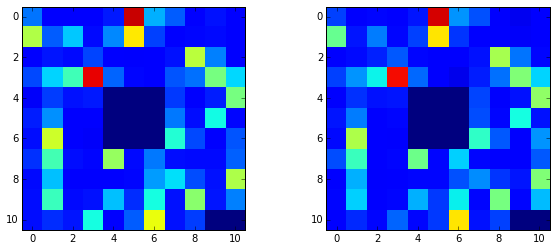

In [10]:
# Compare images <==>  LOOKS GOOD!
plt.close(0)
plt.figure(0, figsize=(10, 4))
vmin = -50
vmax = 450
plt.subplot(1, 2, 1)
plt.imshow(dark_cal_map, vmin=vmin, vmax=vmax, interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(dynam_dark_map, vmin=vmin, vmax=vmax, interpolation='nearest');